## Snakemake for Converting GMET Forcing to Snakemake ##

Initial workflow file to test capabilities of [snakemake](https://snakemake.readthedocs.io/en/stable/).



In [84]:
from IPython import display

In [87]:
%%writefile ../gmet_to_summa.smk
''' 
gmet to summa snakemake master snakemake file

This snakemake file runs all the steps required to convert GMET forcings to SUMMA forcings.

Original process code: Andy Wood
Adapted to Snakemake: Dave Casson
'''

include: '../rules/gmet_file_prep.smk'
include: '../rules/remap_gmet_to_shp.smk'
include: '../rules/metsim_file_prep.smk'
include: '../rules/run_metsim.smk'
include: '../rules/metsim_to_summa.smk'

def build_ensemble_list(directory):
    ''' Build a list of the ensemble name and the file name for each file in the directory
        e.g. for each file in the directory: ens_forc.tuolumne.01d.2020.001.nc' --> 001/ens_forc.tuolumne.01d.2020.001.nc
    '''
    
    path = Path(directory)
    files = path.glob('*') 
    ensemble_list = set()  

    for file in files:
        if file.exists():
            filename = file.stem  # Get the filename without the extension
            directory_name = filename[-3:]  # Get the last three characters
            ensemble_list.add(Path(directory_name, filename)) # Create and add the ens/filename.nc path

    return ensemble_list

# Read all forcing files and create a list based on the output directory (i.e. ens/filename.nc)
ensemble_list = build_ensemble_list(config['forcing']['forcing_dir'])

rule gmet_to_summa:
    input:
        expand(Path(config['summa']['summa_forcing_dir'],'{forcing_file}.nc'), forcing_file = ensemble_list)
        

Overwriting ../gmet_to_summa.smk


In [88]:
! snakemake --unlock -s ../gmet_to_summa.smk --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml
! snakemake -s ../gmet_to_summa.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 

WorkflowError in file /Users/drc858/GitHub/gmet_to_summa_snakemake_backup/workflow/gmet_to_summa.smk, line 10:
Failed to open source file /Users/drc858/GitHub/gmet_to_summa_snakemake_backup/workflow/../rules/gmet_file_prep.smk
FileNotFoundError: [Errno 2] No such file or directory: '/Users/drc858/GitHub/gmet_to_summa_snakemake_backup/workflow/../rules/gmet_file_prep.smk'
  File "/Users/drc858/GitHub/gmet_to_summa_snakemake_backup/workflow/gmet_to_summa.smk", line 10, in <module>
WorkflowError in file /Users/drc858/GitHub/gmet_to_summa_snakemake_backup/workflow/gmet_to_summa.smk, line 10:
Failed to open source file /Users/drc858/GitHub/gmet_to_summa_snakemake_backup/workflow/../rules/gmet_file_prep.smk
FileNotFoundError: [Errno 2] No such file or directory: '/Users/drc858/GitHub/gmet_to_summa_snakemake_backup/workflow/../rules/gmet_file_prep.smk'
  File "/Users/drc858/GitHub/gmet_to_summa_snakemake_backup/workflow/gmet_to_summa.smk", line 10, in <module>


Building DAG of jobs...


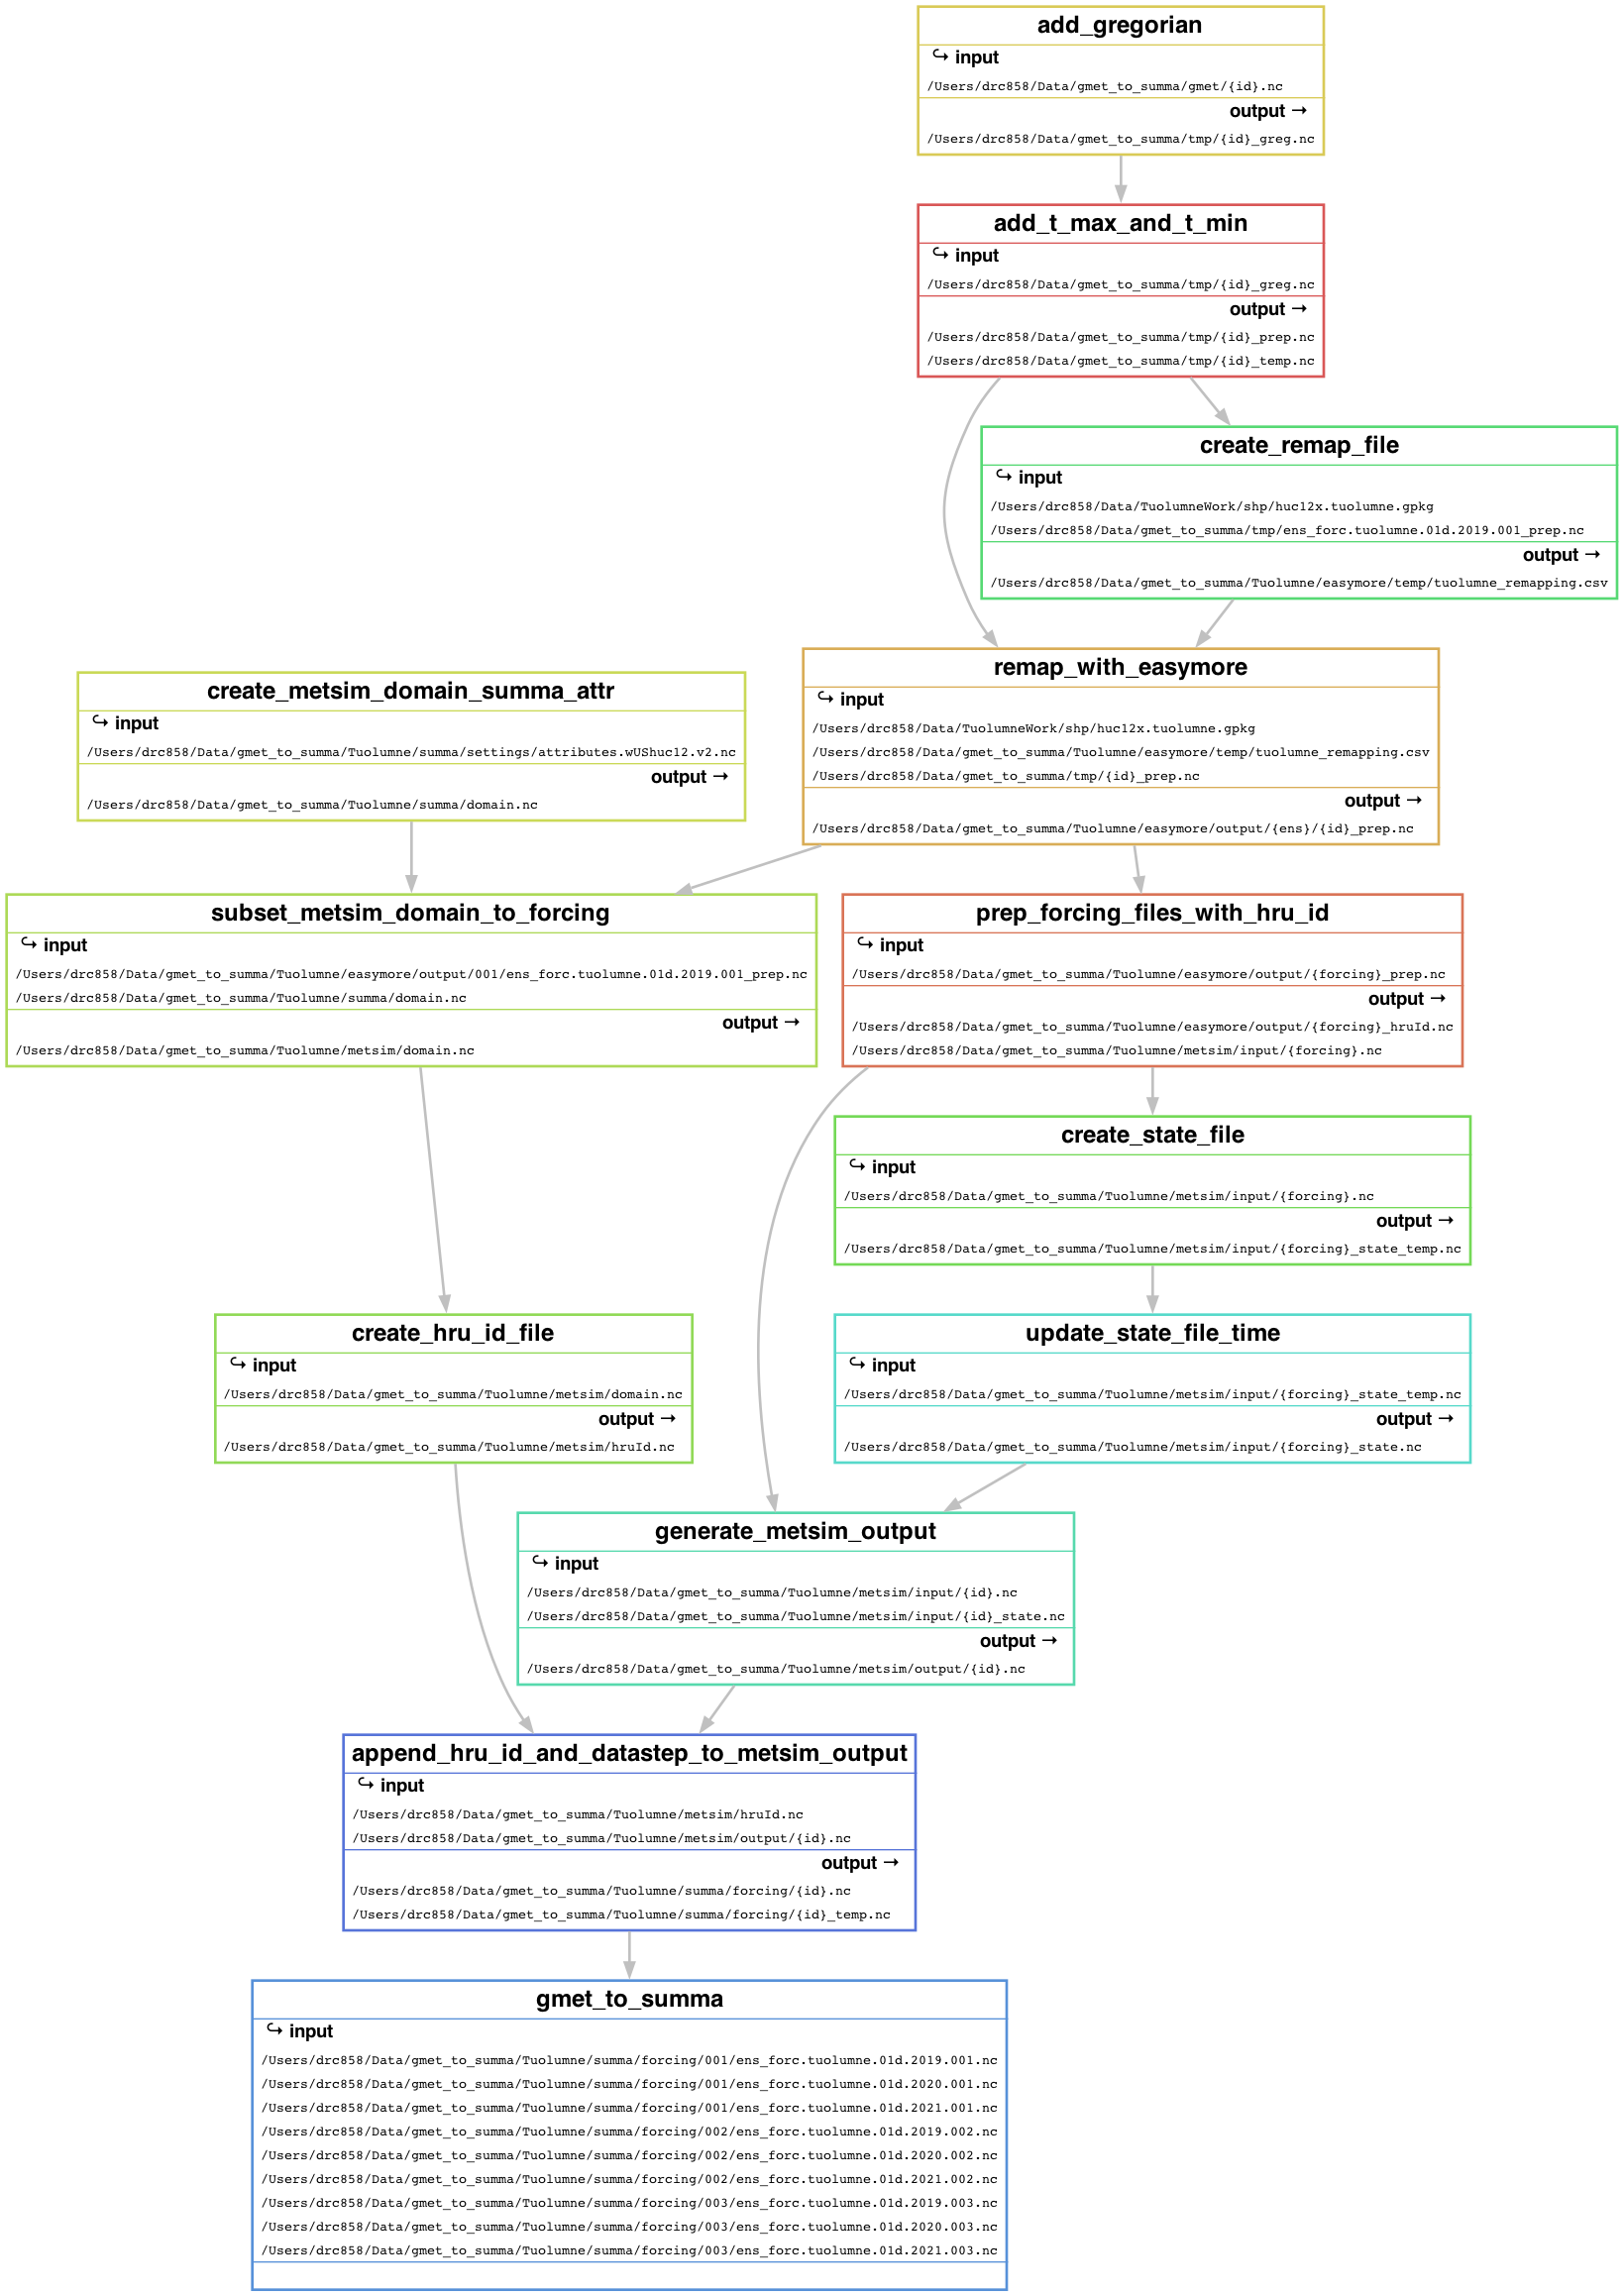

In [73]:
# Snake Command line to build the image
! snakemake -s ./gmet_to_summa.smk --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml --filegraph | dot -Tpng > ../reports/gmet_to_summa.png
# Python command to visualise the built image in our notebook
display.Image('../reports/gmet_to_summa.png')

### Prep GMET files for processing ###

In [60]:
%%writefile ../rules/gmet_file_prep.smk

# This Snakemake file prepares the GMET data for use in 
from pathlib import Path

#Set input and output directories
forcing_dir = config['forcing']['forcing_dir']
file_tmp_dir = config['forcing']['tmp_forcing_dir']

#Set the list of forcing files to process
#The id is the name of the forcing file without the extension
gmet_forcing_files, = glob_wildcards(Path(forcing_dir,"{id}.nc"))

#This first rule establishes the output files that will be created
rule gmet_file_prep:
    input:
        expand(Path(file_tmp_dir,"{id}_prep.nc"), id=gmet_forcing_files)

#Add greogrian calendar to the time variable, needed for easymore  
rule add_gregorian:
    input:  
        Path(forcing_dir,"{id}.nc")
    output: 
        temp(Path(file_tmp_dir,"{id}_greg.nc"))
    shell: 
        'ncatted -a "calendar,time,o,c,"gregorian"" {input} {output}'

#Process temperature data to create t_max and t_min
rule add_t_max_and_t_min:
    input: 
        input_file = Path(file_tmp_dir,"{id}_greg.nc")
    output:
        temp = temp(Path(file_tmp_dir,"{id}_temp.nc")),
        output_file =Path(file_tmp_dir,"{id}_prep.nc")
    shell:
        """
        ncap2 -s "t_max = t_mean+0.5+t_range" -A {input.input_file} {output.temp};
        ncap2 -s "t_min = t_mean+0.5-t_range" -A {output.temp};
        ncatted -O -a long_name,t_max,o,c,"estimated daily maximum temperature" {output.temp};
        ncatted -O -a long_name,t_min,o,c,"estimated daily minimum temperature" {output.temp};
        cp {output.temp} {output.output_file}
        """

Overwriting ../rules/gmet_file_prep.smk


### Run snakemake file

In [49]:
! snakemake --unlock -s ../rules/gmet_file_prep.smk --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml
! snakemake -s ../rules/gmet_file_prep.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 

Unlocking working directory.
Building DAG of jobs...
candidate job all
    wildcards: 
candidate job add_t_max_and_t_min
    wildcards: id=ens_forc.tuolumne.01d.2019.002
candidate job add_gregorian
    wildcards: id=ens_forc.tuolumne.01d.2019.002
selected job add_gregorian
    wildcards: id=ens_forc.tuolumne.01d.2019.002
file /Users/drc858/Data/gmet_to_summa/tmp/ens_forc.tuolumne.01d.2019.002_greg.nc:
    Producer found, hence exceptions are ignored.

selected job add_t_max_and_t_min
    wildcards: id=ens_forc.tuolumne.01d.2019.002
file /Users/drc858/Data/gmet_to_summa/tmp/ens_forc.tuolumne.01d.2019.002_prep.nc:
    Producer found, hence exceptions are ignored.

candidate job add_t_max_and_t_min
    wildcards: id=ens_forc.tuolumne.01d.2021.003
candidate job add_gregorian
    wildcards: id=ens_forc.tuolumne.01d.2021.003
selected job add_gregorian
    wildcards: id=ens_forc.tuolumne.01d.2021.003
file /Users/drc858/Data/gmet_to_summa/tmp/ens_forc.tuolumne.01d.2021.003_greg.nc:
    Produce

## Remap GMET to SHP ##

In [61]:
%%writefile ../rules/remap_gmet_to_shp.smk

# Import needed packages
from pathlib import Path
import sys
sys.path.append('../')
from scripts import remap_forcing_to_shp

# Create a list of the the original forcing files
forcing_dir = config['forcing']['forcing_dir']
file_base, deg_base,years,ens = glob_wildcards(Path(forcing_dir, "{file_name}.{deg}.{year}.{ens}.nc"))

config['input_shp'] = Path(config['base_settings']['shp_dir'], config['base_settings']['catchment_shp'])
config['easymore_output_dir'] = Path(config['easymore']['output_dir'])
config['easymore_temp_dir'] = Path(config['easymore']['temp_dir'])

# Create a list of the temporary forcing files produced in the last workflow
file_tmp_dir = Path(config['forcing']['tmp_forcing_dir'])
tmp_forcing_files = list(file_tmp_dir.glob('*'))
easymore_output = Path(config['easymore']['output_dir'])

# Define the output files that are created
shape_file_from_forcing = Path(config['easymore']['intersect_dir'], config['easymore']['forcing_shp'])
remap_file_str = config['base_settings']['case_name'] + '_remapping.csv'
remap_file = Path(config['easymore']['temp_dir'], remap_file_str)
       
rule remap_gmet_to_shp:
    input:
        expand(Path(easymore_output,"{ens}","{file_base}.{deg}.{year}.{ens}_prep.nc"), file_base=file_base, deg=deg_base, year=years, ens=ens)

# Define rule to run file remapping when remap file exists
rule create_remap_file:
    input:
        input_forcing_file = tmp_forcing_files[0],
        input_shp = config['input_shp']
    output:
        remap_csv = remap_file
    run:
        remap_forcing_to_shp.remap_with_easymore(config, input.input_forcing_file ,input.input_shp, output.remap_csv, only_create_remap_csv=True)

# Define rule to run file remapping when remap file exists
rule remap_with_easymore:
    input:
        input_forcing = Path(file_tmp_dir,"{id}_prep.nc"),
        input_shp = config['input_shp'],
        remap_csv = remap_file
    output:
        output_forcing = Path(config['easymore_output_dir'],"{ens}","{id}_prep.nc", ens=ens)
    run:
        remap_forcing_to_shp.remap_with_easymore(config, input.input_forcing,input.input_shp,input.remap_csv,ens_member={wildcards.ens})




Overwriting ../rules/remap_gmet_to_shp.smk


In [69]:
! snakemake --unlock -s ../rules/remap_gmet_to_shp.smk  --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 
! snakemake -s ../rules/remap_gmet_to_shp.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml

Unlocking working directory.
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).
Complete log: .snakemake/log/2023-07-10T203522.767258.snakemake.log


Building DAG of jobs...


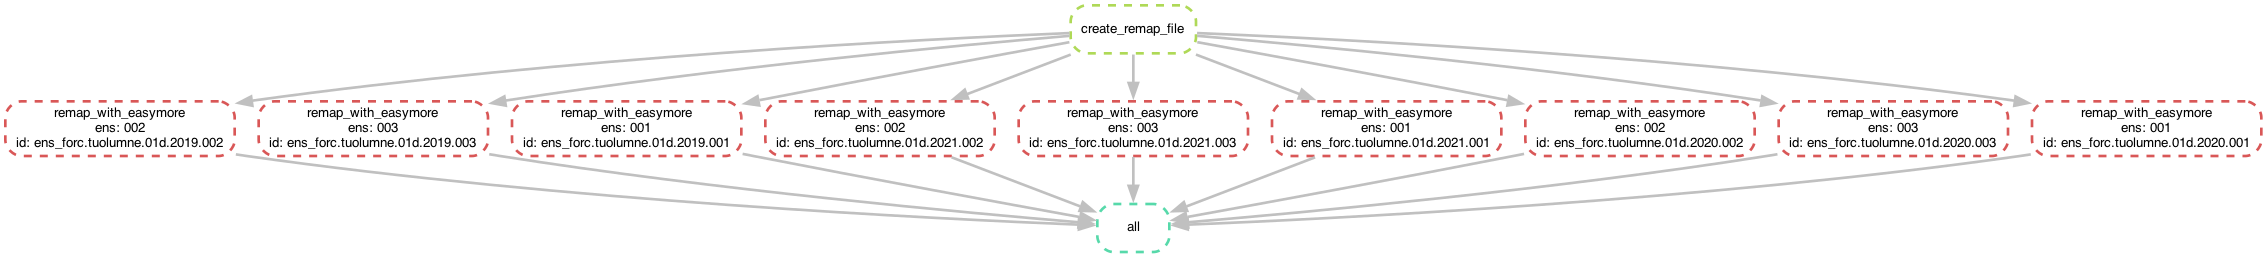

In [74]:
# Snake Command line to build the image
! snakemake -s ../rules/remap_gmet_to_shp.smk --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml --dag | dot -Tpng > ../reports/remap_gmet_to_shp.png
# Python command to visualise the built image in our notebookcond
display.Image("../reports/remap_gmet_to_shp.png")

## Prepare gmet files for metsim ##

In [67]:
%%writefile ../rules/metsim_file_prep.smk

from pathlib import Path
import sys
import xarray as xr
import numpy as np
import pandas as pd

def list_files_in_subdirectory(directory, suffix_to_remove):
    path = Path(directory)
    file_paths = [file.relative_to(path).as_posix().replace(suffix_to_remove, "") for file in path.glob('**/*') if file.is_file()]
    return file_paths

input_file_suffix = '_prep.nc'
input_forcing_list = list_files_in_subdirectory(Path(config['easymore']['output_dir']), input_file_suffix)

easymore_output = Path(config['easymore']['output_dir']) 
metsim_input = Path(config['metsim']['metsim_input_dir'])

def create_state_file(input_forcing_file, output_state_file,timestep_hrs=24):
    # Open the input file
    ds = xr.open_dataset(input_forcing_file)
    # Get the time variable
    time_var = ds['time']
    # Get the number of records
    nrecs = len(time_var)
    # Get the start time of the original file
    end_time = time_var[-1].values
    # Select the last 90 days of data
    data = ds.sel(time=slice(end_time - np.timedelta64(89 * 24 * 3600, 's'), end_time))
    # Shift the time nrecs days previously
    data['time'] = data['time'] - np.timedelta64(nrecs * timestep_hrs * 3600, 's')
    # Output the data to a new file
    data.to_netcdf(output_state_file)
    
def subset_domain_to_forcing(domain_input_nc, forcing_file, domain_subset_nc):
    """Subset domain file to forcing with smaller domain"""

    # Open NetCDF to xarray dataset
    domain_ds = xr.open_dataset(domain_input_nc)
    forcing_ds = xr.open_dataset(forcing_file)

    # Return only domain hrus that match the forcing hrus
    domain_subset = domain_ds.where(domain_ds.hruId.isin(forcing_ds.hruId), drop=True)
    # Trim further to only remaining grus. Otherwise drop of gru could be used.
    domain_gru = domain_subset.gruId.where(
        domain_ds.gruId.isin(domain_subset.hru2gruId), drop=True
    )
    domain_subset["gruId"] = domain_gru[0]

    # Sort by hruId
    domain_subset = domain_subset.sortby("hruId")

    domain_ds.close()
    forcing_ds.close()

    # Set filename and output to netcdf
    domain_subset.to_netcdf(domain_subset_nc)

def update_time_units(input_file, output_file):
    """Update time encoding in netcdf file"""
    
    dataset = xr.open_dataset(input_file)
    dataset.time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
    dataset.to_netcdf(output_file)
    dataset.close()

rule prepare_metsim_files:
    input:
         expand(Path(metsim_input,"{forcing}.nc"), forcing = input_forcing_list),
         expand(Path(metsim_input,"{forcing}_state.nc"), forcing = input_forcing_list),
         Path(config["metsim"]["metsim_dir"], config["metsim"]["domain_nc"])

         
# Create metsim domain file from an existing summa attribute file
rule create_metsim_domain_summa_attr:
    input:
        attr_nc = Path(config["summa"]["attr_nc"])
    output:
        domain_nc = Path(config["summa"]["summa_dir"], config["metsim"]["domain_nc"])
    shell:
        'ncap2 -O -s "mask=elevation*0+1" {input.attr_nc} {output.domain_nc}'

rule subset_metsim_domain_to_forcing:
    input:
        domain_nc = Path(config["summa"]["summa_dir"], config["metsim"]["domain_nc"]),
        forcing_file = Path(easymore_output,f'{input_forcing_list[0]}{input_file_suffix}')
    output:
        subset_nc = Path(config["metsim"]["metsim_dir"], config["metsim"]["domain_nc"])
    run:
        subset_domain_to_forcing(input.domain_nc, input.forcing_file, output.subset_nc)

# Define rule to run file remapping when remap file exists
rule prep_forcing_files_with_hru_id:
    input:
        input_forcing = Path(easymore_output,"{forcing}_prep.nc")

    output:
        hru_id_temp = temp(Path(easymore_output,"{forcing}_hruId.nc")),
        hru_id = Path(metsim_input,"{forcing}.nc")
    shell:
        """
        ncap2 -O -s "hru=array(0,1,hruId)" {input.input_forcing} {output.hru_id_temp};
        ncatted -O -a long_name,hru,a,c,"hru coordinate index" {output.hru_id_temp} {output.hru_id}
        """
        
rule create_state_file:
    input:
        input_forcing_file = Path(metsim_input,"{forcing}.nc")
    output:
        output_state_file = Path(metsim_input,"{forcing}_state_temp.nc")
    run:
        create_state_file(input.input_forcing_file, output.output_state_file)

rule update_state_file_time:
    input:
        input_state_file = Path(metsim_input,"{forcing}_state_temp.nc")
    output:
        output_state_file = Path(metsim_input,"{forcing}_state.nc")
    run:
        update_time_units(input.input_state_file, output.output_state_file)



Overwriting ../rules/metsim_file_prep.smk


In [69]:
! snakemake --unlock -s ../rules/metsim_file_prep.smk  --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 
! snakemake -s ../rules/metsim_file_prep.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 

Unlocking working directory.
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).
Complete log: .snakemake/log/2023-07-12T153543.051468.snakemake.log


## Run metsim ##

In [28]:
%%writefile ../rules/run_metsim.smk
from pathlib import Path
import xarray as xr
import yaml
from metsim import MetSim
import shutil

def list_files_in_subdirectory(directory, suffix_to_remove):
    path = Path(directory)
    file_paths = [file.relative_to(path).as_posix().replace(suffix_to_remove, "") for file in path.glob('**/*') if file.is_file()]
    return file_paths

input_file_suffix = '_prep.nc'
input_forcing_list = list_files_in_subdirectory(Path(config['easymore']['output_dir']), input_file_suffix)

gmet_forcing_files, = glob_wildcards(Path(config['forcing']['forcing_dir'], "{id}.nc"))

def read_metsim_base_config(settings):
    """Create metsim domain file from summa model attribute file"""

    metsim_base_path = Path(
        settings["metsim"]["metsim_base_config"]
    )
    with open(metsim_base_path) as file:
        metsim_base_config = OrderedDict(yaml.load(file, Loader=yaml.FullLoader))

    return metsim_base_config

def rename_ms_output(ms,new_file_name):
    ms_output = [ms._get_output_filename(times) for times in ms._times]

    if len(ms_output) == 1:
        ms_output_file = Path(ms_output[0])
        ms_output_file.rename(new_file_name)
    elif len(ms_output) > 1:
        output = xr.open_mfdataset(ms_output, concat_dim='time')
        output.to_netcdf(new_file_name)
    elif len(ms_output) == 0:
        raise ValueError("No output files were generated by MetSim")

def get_time_range(nc_file):
    # Open the netCDF file
    ds = xr.open_dataset(nc_file)
    # Get the time variable
    time_var = ds['time']
    # Get the start and end times
    start_time = time_var[0].values.astype('datetime64[D]').astype(str)
    end_time = time_var[-1].values.astype('datetime64[D]').astype(str)
    # Close the netCDF file
    ds.close()
    # Return the start and end times
    return start_time, end_time

def create_metsim_config(config, input_forcing_file,input_state_file,output_file):
    """Create metsim configuration file, both from master configuration file and from hardwired settings"""

    metsim_base_config = read_metsim_base_config(config)
    start_time, end_time = get_time_range(input_forcing_file)
    print(str(start_time), str(end_time))
    metsim_base_config["start"] = str(start_time)
    metsim_base_config["stop"] = str(end_time)
    metsim_base_config["out_freq"] = config['metsim']['out_freq']
    metsim_base_config["scheduler"] = "threading"
    input_forcing_str = str(input_forcing_file)
    metsim_base_config["forcing"] = input_forcing_str
    state_file_str = str(input_state_file)
    metsim_base_config["state"] = state_file_str
    metsim_base_config["domain"] = os.path.join(
        config["metsim"]["metsim_dir"], config["metsim"]["domain_nc"]
    )
    output_file_path = Path(output_file)
    metsim_base_config['out_dir'] = str(output_file_path.parent)
    metsim_base_config['time_step'] = config['metsim']['timestep_minutes']

    ms = MetSim(metsim_base_config)

    return ms

rule run_metsim:
    input:
        expand(Path(config['metsim']['metsim_output_dir'],"{id}.nc"), id=input_forcing_list)

rule generate_metsim_output:
    input:
         metsim_input_forcing = Path(config['metsim']['metsim_input_dir'],"{id}.nc"),
         metsim_input_state = Path(config['metsim']['metsim_input_dir'],"{id}_state.nc")
    output:
        metsim_output_forcing = Path(config['metsim']['metsim_output_dir'],"{id}.nc")
    run:
        ms = create_metsim_config(config, input.metsim_input_forcing,input.metsim_input_state,output.metsim_output_forcing)
        ms.run()
        rename_ms_output(ms,output.metsim_output_forcing)



Overwriting ../rules/run_metsim.smk


In [29]:
! snakemake --unlock -s ../rules/run_metsim.smk  --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 
! snakemake -s ../rules/run_metsim.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 

Unlocking working directory.
Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 8
Rules claiming more threads will be scaled down.
Job stats:
job                       count    min threads    max threads
----------------------  -------  -------------  -------------
generate_metsim_output        9              1              1
run_metsim                    1              1              1
total                        10              1              1

Select jobs to execute...

[Wed Jul 12 13:54:47 2023]
rule generate_metsim_output:
    input: /Users/drc858/Data/gmet_to_summa/Tuolumne/metsim/input/001/ens_forc.tuolumne.01d.2021.001.nc, /Users/drc858/Data/gmet_to_summa/Tuolumne/metsim/input/001/ens_forc.tuolumne.01d.2021.001_state.nc
    output: /Users/drc858/Data/gmet_to_summa/Tuolumne/metsim/output/001/ens_forc.tuolumne.01d.2021.001.nc
    jobid: 2
    reason: Missing output files: /Users/drc858/Data/gmet_to_summa/Tuolumne/metsim/output/001/ens_forc.tuolumne.01d.2021.001.nc
 

## Convert metsim output to summa ready input ##

In [44]:
%%writefile ../rules/metsim_to_summa.smk
from pathlib import Path

def list_files_in_subdirectory(directory, suffix_to_remove):
    path = Path(directory)
    file_paths = [file.relative_to(path).as_posix().replace(suffix_to_remove, "") for file in path.glob('**/*') if file.is_file()]
    return file_paths

input_file_suffix = '.nc'
input_forcing_list = list_files_in_subdirectory(config['metsim']['metsim_output_dir'], input_file_suffix)

rule metsim_to_summa:
    input:
        expand(Path(config['summa']['summa_forcing_dir'],"{id}.nc"), id=input_forcing_list)

rule create_hru_id_file:
    input:
        subset_domain_file = Path(config["metsim"]["metsim_dir"], config["metsim"]["domain_nc"])
    output:
        hru_id_file = temp(Path(config["metsim"]["metsim_dir"], 'hruId.nc'))
    shell:
        'ncks -v hruId {input.subset_domain_file} {output.hru_id_file}'

rule append_hru_id_and_datastep_to_metsim_output:
    input:
        input_metsim_file = Path(config['metsim']['metsim_output_dir'],"{id}.nc"),
        hru_id_file = Path(config["metsim"]["metsim_dir"], 'hruId.nc')
    output:
        output_metsim_file_temp = temp(Path(config['summa']['summa_forcing_dir'],"{id}_temp.nc")),
        output_metsim_file = Path(config['summa']['summa_forcing_dir'],"{id}.nc")
    params:
        timestep = int(config["metsim"]["timestep_minutes"]) * 60
    shell:
        """
        ncks -h -A {input.hru_id_file} {input.input_metsim_file}
        ncks -O -C -x -v hru {input.input_metsim_file} {output.output_metsim_file_temp}
        ncap2 -s "data_step={params.timestep}" {output.output_metsim_file_temp} --append {output.output_metsim_file}
        """

Overwriting ../rules/metsim_to_summa.smk


In [45]:
! snakemake --unlock -s ../rules/metsim_to_summa.smk  --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 
! snakemake -s ../rules/metsim_to_summa.smk -c 8 --configfile /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/config/gmet_to_summa_config.yaml 

Unlocking working directory.
Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 8
Rules claiming more threads will be scaled down.
Job stats:
job                                            count    min threads    max threads
-------------------------------------------  -------  -------------  -------------
append_hru_id_and_datastep_to_metsim_output        9              1              1
metsim_to_summa                                    1              1              1
total                                             10              1              1

Select jobs to execute...

[Wed Jul 12 14:52:59 2023]
rule append_hru_id_and_datastep_to_metsim_output:
    input: /Users/drc858/Data/gmet_to_summa/Tuolumne/metsim/output/003/ens_forc.tuolumne.01d.2021.003.nc, /Users/drc858/Data/gmet_to_summa/Tuolumne/metsim/hruId.nc
    output: /Users/drc858/Data/gmet_to_summa/Tuolumne/summa/forcing/003/ens_forc.tuolumne.01d.2021.003_temp.nc, /Users/drc858/Data/gmet_to_summa/Tuolumne/summa/fo